In [4]:
pip install scikit-learn

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 12.4 MB/s eta 0:00:00a 0:00:01
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 12.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# Define paths
DATA_PATH_G = "./data/games.csv"
DATA_PATH_T = "./data/teams.csv"
OUTPUT_DIR = "./output"
PLOTS_DIR = "./plots"

In [6]:
games = pd.read_csv(DATA_PATH_G)
teams = pd.read_csv(DATA_PATH_T)

In [ ]:
#reused code that sucheer wrote cuz its clean lol

home = games[['SEASON', 'HOME_TEAM_ID', 'PTS_home', 'FG_PCT_home', 'AST_home', 'REB_home', 'HOME_TEAM_WINS']].copy()
home = home.rename(columns={
    'HOME_TEAM_ID': 'TEAM_ID',
    'PTS_home': 'PTS',
    'FG_PCT_home': 'FG_PCT',
    'AST_home': 'AST',
    'REB_home': 'REB',
    'HOME_TEAM_WINS': 'WIN'
})

away = games[['SEASON', 'VISITOR_TEAM_ID', 'PTS_away', 'FG_PCT_away', 'AST_away', 'REB_away', 'HOME_TEAM_WINS']].copy()
away = away.rename(columns={
    'VISITOR_TEAM_ID': 'TEAM_ID',
    'PTS_away': 'PTS',
    'FG_PCT_away': 'FG_PCT',
    'AST_away': 'AST',
    'REB_away': 'REB'
})

away['WIN'] = 1 - away['HOME_TEAM_WINS']

all_games = pd.concat([home, away], ignore_index=True)

agg_stats = all_games.groupby(['SEASON', 'TEAM_ID']).agg(
    wins=('WIN', 'sum'),
    avg_pts=('PTS', 'mean'),
    avg_fg_pct=('FG_PCT', 'mean'),
    avg_ast=('AST', 'mean'),
    avg_reb=('REB', 'mean')
).reset_index()
agg_stats = agg_stats.merge(teams, on='TEAM_ID', how='left')

X = agg_stats[['avg_pts', 'avg_fg_pct', 'avg_ast', 'avg_reb']]
y = agg_stats['wins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
#KNN
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
mse_knn = mean_squared_error(y_test, y_pred_knn)

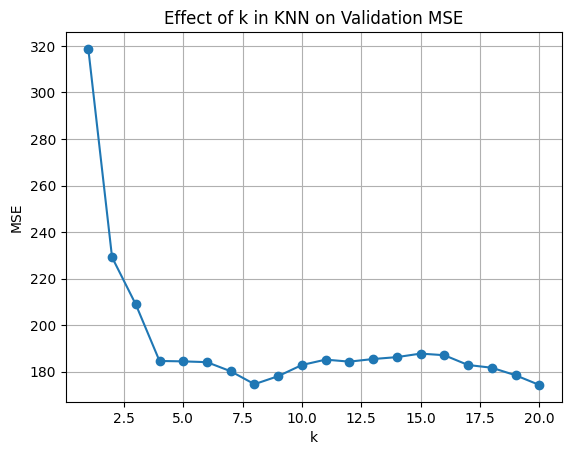

In [9]:
k_values = list(range(1, 21))
mse_values = []

for k in k_values:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    mse_values.append(mean_squared_error(y_test, preds))

plt.figure()
plt.plot(k_values, mse_values, marker='o')
plt.title("Effect of k in KNN on Validation MSE")
plt.xlabel("k")
plt.ylabel("MSE")
plt.grid(True)
plt.show()


In [10]:
#SVR
svr = SVR(kernel='rbf', C=1.0, gamma='scale')
svr.fit(X_train_scaled, y_train)
y_pred_svr = svr.predict(X_test_scaled)
mse_svr = mean_squared_error(y_test, y_pred_svr)


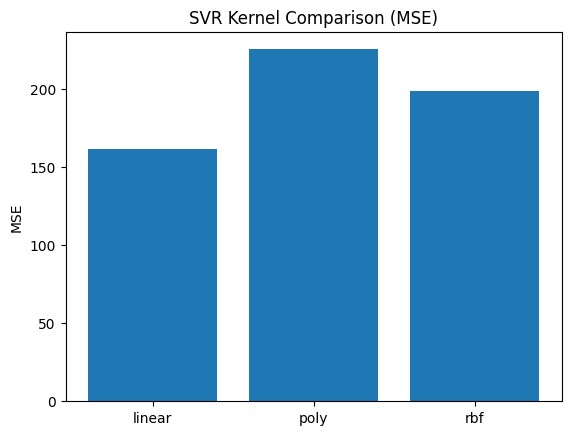

In [11]:
svr_linear = SVR(kernel='linear').fit(X_train_scaled, y_train)
svr_poly = SVR(kernel='poly', degree=3).fit(X_train_scaled, y_train)
svr_rbf = SVR(kernel='rbf').fit(X_train_scaled, y_train)

mse_linear = mean_squared_error(y_test, svr_linear.predict(X_test_scaled))
mse_poly = mean_squared_error(y_test, svr_poly.predict(X_test_scaled))
mse_rbf = mean_squared_error(y_test, svr_rbf.predict(X_test_scaled))

plt.figure()
plt.bar(['linear', 'poly', 'rbf'], [mse_linear, mse_poly, mse_rbf])
plt.title("SVR Kernel Comparison (MSE)")
plt.ylabel("MSE")
plt.show()

In [12]:
#DTR
dt = DecisionTreeRegressor(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)

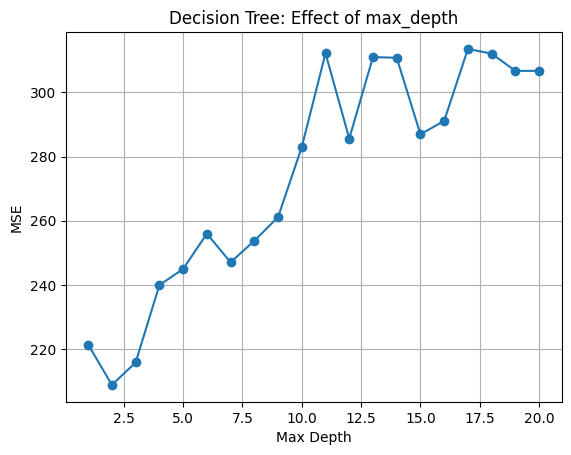

In [13]:
depths = range(1, 21)
mse_depth = []

for d in depths:
    model = DecisionTreeRegressor(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse_depth.append(mean_squared_error(y_test, preds))

plt.figure()
plt.plot(depths, mse_depth, marker='o')
plt.title("Decision Tree: Effect of max_depth")
plt.xlabel("Max Depth")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

In [14]:
#FEATURE REDUCTION
X_reduced = X[['avg_pts', 'avg_fg_pct']]
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reduced, y, test_size=0.2, random_state=42)
X_train_r_scaled = scaler.fit_transform(X_train_r)
X_test_r_scaled = scaler.transform(X_test_r)

model_knn_reduced = KNeighborsRegressor(n_neighbors=5).fit(X_train_r_scaled, y_train_r)
mse_knn_reduced = mean_squared_error(y_test_r, model_knn_reduced.predict(X_test_r_scaled))


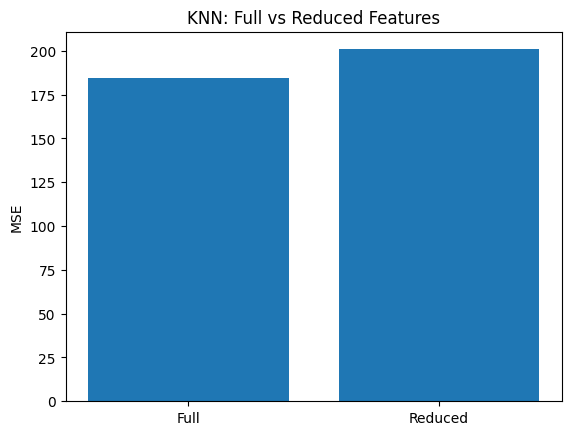

In [15]:
#COMPARE PLOT BETWEEN FULL AND REDUCED
plt.figure()
plt.bar(['Full', 'Reduced'], [mse_knn, mse_knn_reduced])
plt.title("KNN: Full vs Reduced Features")
plt.ylabel("MSE")
plt.show()


In [16]:
#SUMMARY STATS
print("Final MSE Summary:")
print(f"KNN (k=5): {mse_knn:.2f}")
print(f"SVR (RBF): {mse_svr:.2f}")
print(f"Decision Tree (depth=5): {mse_dt:.2f}")
print(f"KNN with reduced features: {mse_knn_reduced:.2f}")
print(f"SVR (linear): {mse_linear:.2f}, poly: {mse_poly:.2f}, rbf: {mse_rbf:.2f}")

Final MSE Summary:
KNN (k=5): 184.46
SVR (RBF): 198.36
Decision Tree (depth=5): 244.95
KNN with reduced features: 200.92
SVR (linear): 161.68, poly: 225.26, rbf: 198.36


In [17]:
X_distorted = X.copy()
X_distorted['avg_ast'] *= 100
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_distorted, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_d_scaled = scaler.fit_transform(X_train_d)
X_test_d_scaled = scaler.transform(X_test_d)

model_distorted = KNeighborsRegressor(n_neighbors=5).fit(X_train_d_scaled, y_train_d)
mse_distorted = mean_squared_error(y_test_d, model_distorted.predict(X_test_d_scaled))

Text(0, 0.5, 'MSE')

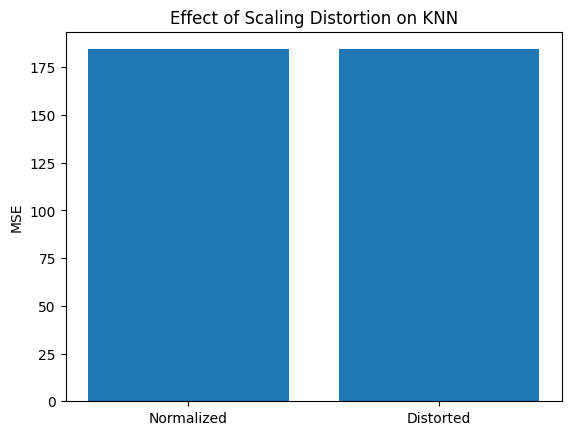

In [18]:
plt.bar(['Normalized', 'Distorted'], [mse_knn, mse_distorted])
plt.title("Effect of Scaling Distortion on KNN")
plt.ylabel("MSE")